In [1]:
from PIL import Image
import os

import torch, torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import time

In [2]:
torch.cuda.is_available()

True

In [3]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
width, height= 224,224
batch_size=32
learning_rate=0.001

In [5]:
train_dir='Training'
test_dir='Testing'

In [6]:
num_classes=len(os.listdir(train_dir))
num_classes

4

In [7]:
# Tensor 변환, 이미지 input size 맞춰주기 등 input data에 대한 전처리
image_transforms={
    'train':transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((width, height)),                  
    ]),
    'test':transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((width, height)),                  
    ])
}


#data 직접 가져와서 transform
data={
    'train':datasets.ImageFolder(root=train_dir, transform=image_transforms['train']),
    'test':datasets.ImageFolder(root=test_dir, transform=image_transforms['test'])
}


train_data_loader=DataLoader(data['train'], batch_size=batch_size, shuffle=True)
test_data_loader=DataLoader(data['test'], batch_size=batch_size, shuffle=False)

In [8]:
len_train=len(data['train'])
len_test=len(data['test'])
print('length of train_data: ',len(data['train']))
print('length of test_data: ',len(data['test']))

length of train_data:  2871
length of test_data:  394


In [9]:
for dir in ['/glioma_tumor', '/meningioma_tumor', '/no_tumor', '/pituitary_tumor']:
    print(dir , ':', len(os.listdir(train_dir+dir)))

/glioma_tumor : 827
/meningioma_tumor : 822
/no_tumor : 395
/pituitary_tumor : 827


In [10]:
indexes={k:v for k,v in data['train'].class_to_idx.items()}
print(indexes)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


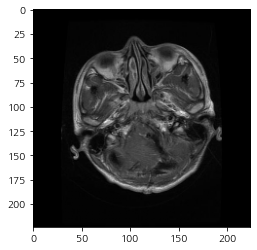

In [11]:
#이미지 보기
for batch_idx, (inputs, targets) in enumerate(train_data_loader):
    if batch_idx==1:
        break
    else:
        img=inputs[batch_idx].numpy()
        plt.imshow(np.transpose(img,(1,2,0)))
        plt.show()

In [12]:
base_model=models.resnet50(pretrained=True)

for param in base_model.parameters():
    param.requires_grad=True
    param.requires_bias=True

n_inputs=base_model.fc.in_features

base_model.fc=nn.Sequential(nn.Linear(n_inputs, 512),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(512,64),
                            nn.ReLU(),
                            nn.Dropout(0.2),
                            nn.Linear(64,32),
                            nn.Linear(32,num_classes),
                            nn.LogSoftmax(dim=1)
                            )
base_model=base_model.to(device)

In [13]:
from torchsummary import summary
summary(base_model, input_size=(3,224,224), device=device.type)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [70]:
criterion=nn.CrossEntropyLoss().to(device)
optimizer=torch.optim.Adam(base_model.parameters(), lr=0.001)

In [71]:
def train(model, loss, optimizer, epochs):
    start=time.time()
    history=[]
    best_acc=0.0
    
    for epoch in range(epochs):
        epoch_start=time.time()
        print('Epoch : {} / {}' .format(epoch+1, epochs))

        model.train()

        train_loss=0.0
        train_acc=0.0

        for i, (inputs, labels) in enumerate(train_data_loader):
            inputs=inputs.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            outputs=model(inputs)

            loss=criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item() * inputs.size(0)

            ret, predictions=torch.max(outputs.data,1)
            correct_counts=predictions.eq(labels.data.view_as(predictions))

            acc=torch.mean(correct_counts.type(torch.FloatTensor))

            train_acc+=acc.item() * inputs.size(0)
    
        avg_train_loss=train_loss/len_train
        avg_train_acc=train_acc/len_train
        print('Training : loss - {:.4f}, Accuracy - {:4f}'.format(avg_train_loss, avg_train_acc))
        history.append([avg_train_loss, avg_train_acc])
    
        
    epoch_end=time.time()
    print("Epoch :{:03d} , Training: loss - {:.4f}, Accuracy - {:4f}, Time : {:4f}s"\
          .format(epoch+1, avg_train_loss, (avg_train_acc)*100, epoch_end-epoch_start))
    
#     torch.save(model.state_dict(), '/models')
#     torch.save('model_2', '/models')
    
    return model, history


In [72]:
epochs=50
train_model, train_history=train(base_model, criterion, optimizer, epochs)

Epoch : 1 / 50
Training : loss - 0.7413, Accuracy - 0.710801
Epoch : 2 / 50
Training : loss - 0.4400, Accuracy - 0.845645
Epoch : 3 / 50
Training : loss - 0.3347, Accuracy - 0.882578
Epoch : 4 / 50
Training : loss - 0.2929, Accuracy - 0.898606
Epoch : 5 / 50
Training : loss - 0.2318, Accuracy - 0.922648
Epoch : 6 / 50
Training : loss - 0.2087, Accuracy - 0.933449
Epoch : 7 / 50
Training : loss - 0.2279, Accuracy - 0.920906
Epoch : 8 / 50
Training : loss - 0.1918, Accuracy - 0.936934
Epoch : 9 / 50
Training : loss - 0.1313, Accuracy - 0.954007
Epoch : 10 / 50
Training : loss - 0.1254, Accuracy - 0.957840
Epoch : 11 / 50
Training : loss - 0.1736, Accuracy - 0.945993
Epoch : 12 / 50
Training : loss - 0.0995, Accuracy - 0.969338
Epoch : 13 / 50
Training : loss - 0.0948, Accuracy - 0.970383
Epoch : 14 / 50
Training : loss - 0.0901, Accuracy - 0.972125
Epoch : 15 / 50
Training : loss - 0.0807, Accuracy - 0.974564
Epoch : 16 / 50
Training : loss - 0.0700, Accuracy - 0.980836
Epoch : 17 / 50
T

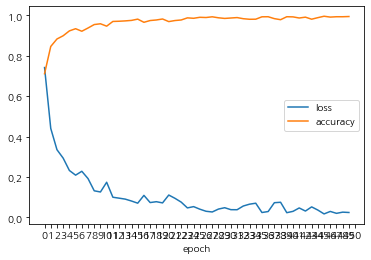

In [73]:
plt.subplots
history=np.array(train_history)
plt.plot(history[:,0])
plt.plot(history[:,1])
plt.legend(['loss', 'accuracy'])
plt.xticks(np.arange(0,epochs+1))
plt.xlabel('epoch')
plt.rcParams['axes.unicode_minus'] = False  
plt.show()

In [74]:
train_model.eval()
correct=0
total=0

with torch.no_grad(): #test -> no gradient update
    for images , labels in test_data_loader:
        images=images.to(device)
        labels=labels.to(device)
        outputs=train_model(images)
        _, predicted= torch.max(outputs.data,1)
        total+=labels.size(0)
        correct+=(predicted==labels).sum().item()
    print('Test Accuracy {} %'.format(round(100*correct/total , 6)))

Test Accuracy 76.903553 %
